In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'ovary_ovary_HCLFetalFemaleGonad2'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/ovary_ovary_HCLFetalFemaleGonad2/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalFemaleGonad_2.AAGCGGAATAAAGATCTT,FetalFemaleGonad_2.CTCGCACGTATTTCGTAA,FetalFemaleGonad_2.AAGCGGGTTGCCGAGATC,FetalFemaleGonad_2.CTGTGTGTTGCCATCAAC,FetalFemaleGonad_2.CTCGCAAGGACTATTTGC
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,1,0,0,0
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0
A2ML1-AS1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,<chr>
FetalFemaleGonad_2.AAAACGAAAACGACGTTG,Gonad,Gonad,NA,normal,1,Female,11W
FetalFemaleGonad_2.AAAACGAAAACGTTCATA,Gonad,Gonad,NA,normal,1,Female,11W
FetalFemaleGonad_2.AAAACGAAAGTTATTCCA,Gonad,Gonad,NA,normal,1,Female,11W
FetalFemaleGonad_2.AAAACGAACCTAAGCGAG,Gonad,Gonad,NA,normal,7,Female,11W
FetalFemaleGonad_2.AAAACGAACCTACGTGGC,Gonad,Gonad,NA,normal,1,Female,11W


[1] "Primordial germ cell_TCL1A high" "Primordial germ cell_TCL1A high"
[3] "Primordial germ cell_TCL1A high" "Neuron"                         
[5] "Primordial germ cell_TCL1A high"

In [5]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


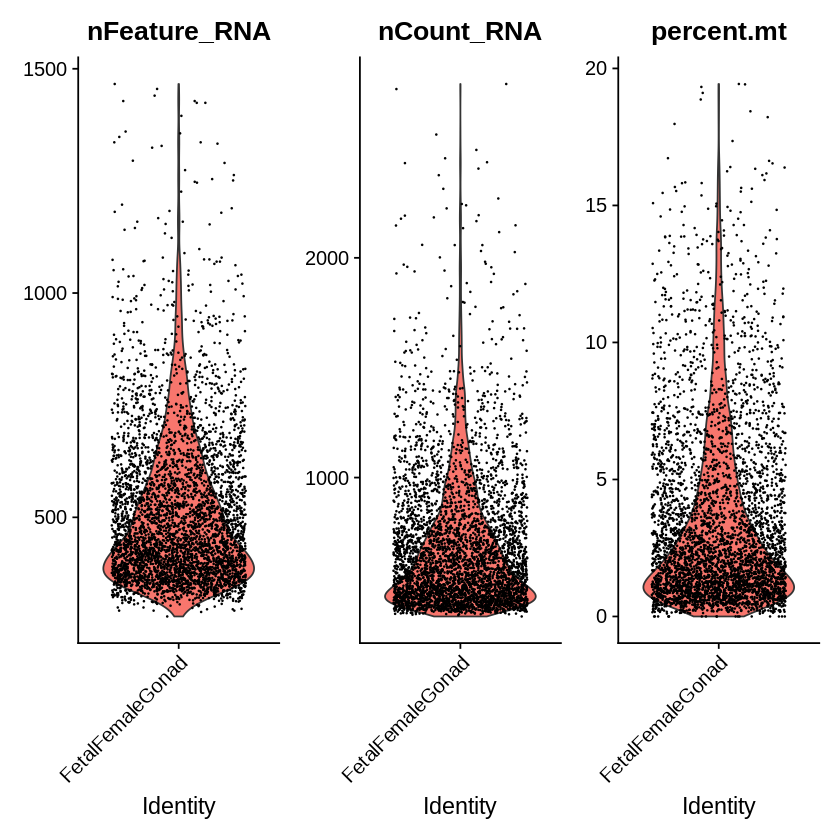

In [6]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [9]:
# QC
nFeature_RNA_range = c(0, 1000)
percent.mt.thre = 15
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [10]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  FOS, HES1, JUNB, ZFP36L1, BTG2, EGR1, MT-ND2, MALAT1, MT-RNR2, DUSP1 
	   TPT1, MT-ND3, MT-ATP6, FOSB, KCTD12, TMSB10, BEX1, MT-ND1, PRKAR2B, MT-RNR1 
	   ZFP36, MT-ND4, SPRR2F, KITLG, GATM, FAM210B, EMX2, MT-CO3, KLF10, VIM 
Negative:  RPS19, RPL36A, RPS6, RPS27, RPS14, RPS23, NDUFAB1, PRDX1, RAN, RPL15 
	   RPS18, RPL37A, RPS3, RPL23A, RPLP1, CALM2, RPS3A, RPS29, SOD1, LAMTOR5 
	   RPL27, RPS26, GTSF1, DNAJC15, RPS20, TCL1A, S100A10, HMGB3, SYCP3, PRDX4 
PC_ 2 
Positive:  UBE2C, TOP2A, PTTG1, CDK1, HMGB2, B2M, LGALS1, NUSAP1, IFITM3, KIAA0101 
	   TUBA1B, CCNA2, CDC20, CDKN3, IFITM2, TPX2, C1QB, CENPF, COL1A1, NUF2 
	   ARL6IP1, CCNB1, AIF1, A2M, PRC1, FBXO5, TMSB10, DCN, HLA-DRA, KRT19 
Negative:  FAM210B, MT1L, KITLG, GATM, CRYM, SAT1, TCL1A, PRKAR2B, VAT1L, CNTNAP4 
	   PRDX1, BEX1, GJA1, NPNT, MT3, NDUFAB1, NR1H4, MT-ND3, GTSF1, TOX3 
	   MME, SOX15, MIR202HG, DSEL, APCDD1L, SYCP3, PRR15, CFLAR, POU5F1, FOXL2 
PC_ 3 
Positive:  RPL34, RPL31, RPS27, RPS14, EEF1A1

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


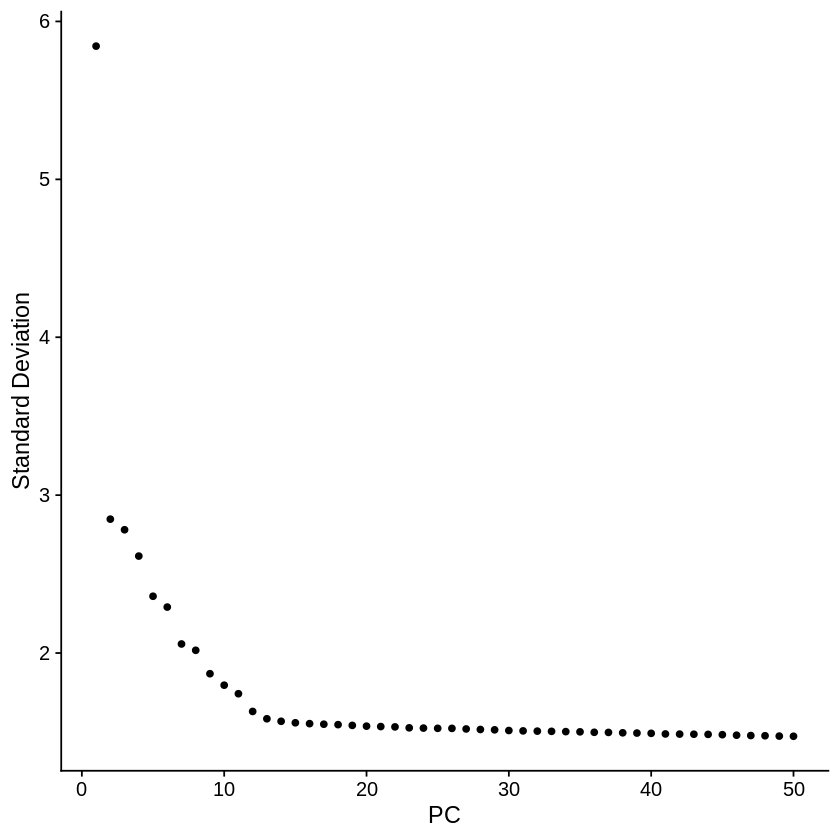

In [12]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [13]:
dev.off()
pcDim = 12 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:23:43 UMAP embedding parameters a = 0.9922 b = 1.112

18:23:43 Read 4120 rows and found 12 numeric columns

18:23:43 Using Annoy for neighbor search, n_neighbors = 30

18:23:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:23:44 Writing NN index file to temp file /tmp/RtmpvSinHj/file65da476041e9

18:23:44 Searching Annoy index using 1 thread, search_k = 3000

18:23:45 Annoy recall = 100%

18:23:45 Commencing smooth kNN distance calibration using 1 thread

18:23:46 Initializing fro

In [18]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.4)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4120
Number of edges: 148822

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8594
Number of communities: 9
Elapsed time: 0 seconds


18:25:14 UMAP embedding parameters a = 0.9922 b = 1.112

18:25:14 Read 4120 rows and found 12 numeric columns

18:25:14 Using Annoy for neighbor search, n_neighbors = 30

18:25:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:25:14 Writing NN index file to temp file /tmp/RtmpvSinHj/file65da728df314

18:25:14 Searching Annoy index using 1 thread, search_k = 3000

18:25:15 Annoy recall = 100%

18:25:16 Commencing smooth kNN distance calibration using 1 thread

18:25:16 Initializing from normalized Laplacian + noise

18:25:16 Commencing optimization for 500 epochs, with 166884 positive edges

18:25:26 Optimization finished



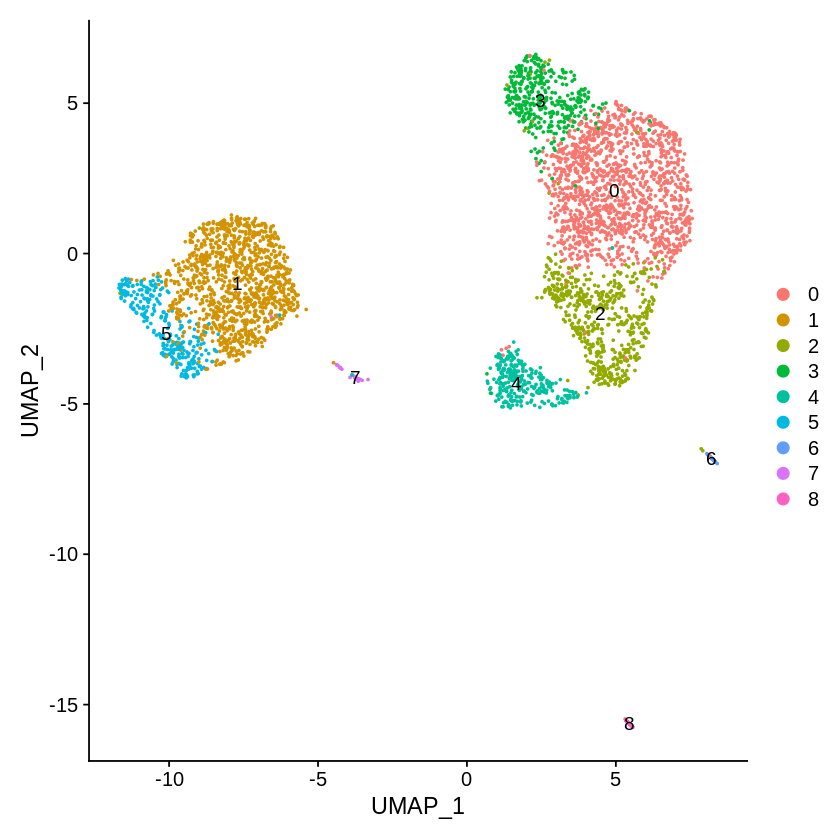

In [19]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [20]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

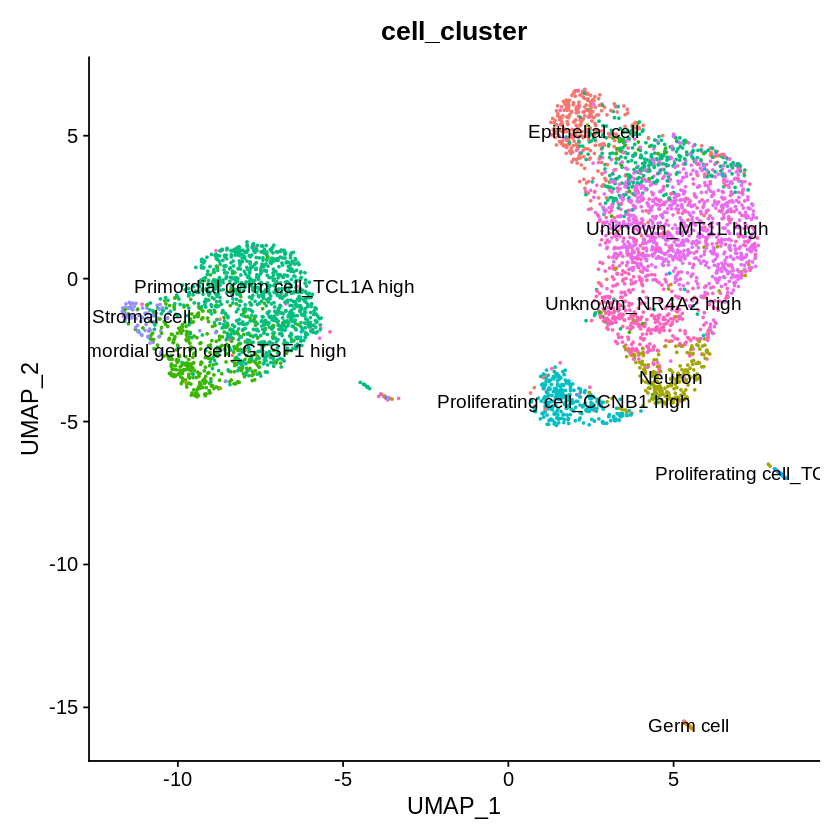

In [21]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [22]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [23]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [24]:
new.cluster.ids <- c("Ovary-Connective tissue-Germ cell-PAGE2B",
                     "Ovary-Connective tissue-Germ cell-POU5F1",
                     "Ovary-Epithelial tissue-Epithelial progenitor cell-NPY",
                     "Ovary-Epithelial tissue-Epithelial cell-KRT18",
                     "Ovary-Connective tissue-Stromal cell-DCN",
                     "Ovary-Connective tissue-Germ cell-TCL1A",
                     "Ovary-Epithelial tissue-Endothelial cell-CDH5",
                     "Unclassified",
                     "Ovary-Connective tissue-Macrophage-C1QB"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [25]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [26]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

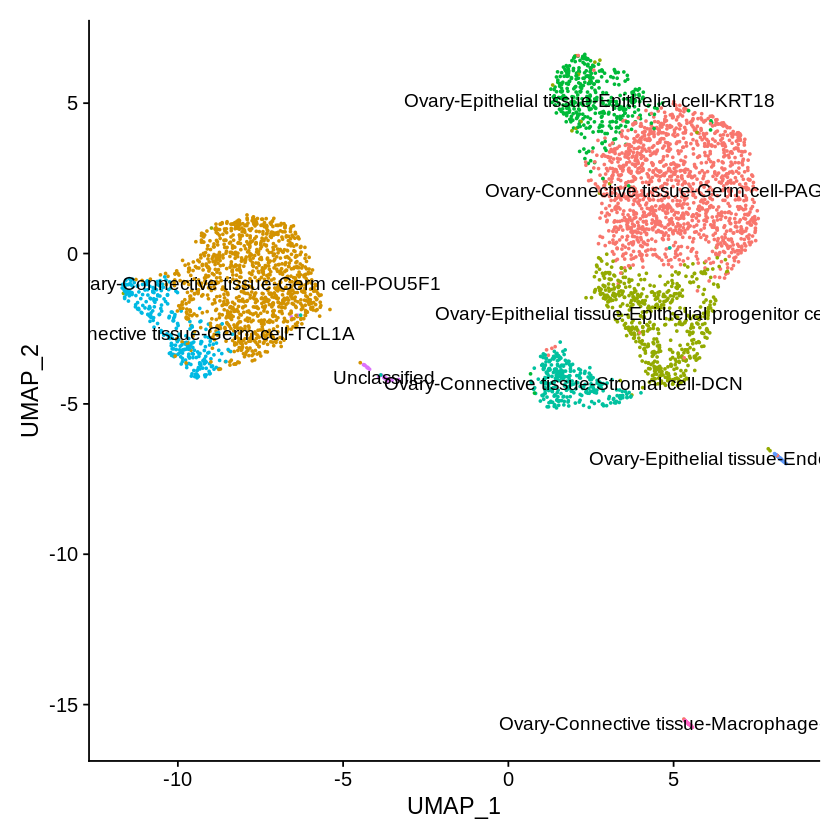

In [27]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [28]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))